In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:35 - loss: 0.2680 - STD: 1.4192e-04 - MAE: 0.5081

 4/64 [>.............................] - ETA: 1s - loss: 0.0965 - STD: 4.2747e-04 - MAE: 0.2466  

 5/64 [=>............................] - ETA: 1s - loss: 0.0802 - STD: 3.8585e-04 - MAE: 0.2150

 6/64 [=>............................] - ETA: 2s - loss: 0.0702 - STD: 3.4186e-04 - MAE: 0.1972

 7/64 [==>...........................] - ETA: 2s - loss: 0.0636 - STD: 3.0317e-04 - MAE: 0.1863

 8/64 [==>...........................] - ETA: 2s - loss: 0.0590 - STD: 2.7070e-04 - MAE: 0.1794

 9/64 [===>..........................] - ETA: 2s - loss: 0.0555 - STD: 2.4365e-04 - MAE: 0.1744

10/64 [===>..........................] - ETA: 2s - loss: 0.0529 - STD: 2.2097e-04 - MAE: 0.1709

11/64 [====>.........................] - ETA: 2s - loss: 0.0508 - STD: 2.0184e-04 - MAE: 0.1682

12/64 [====>.........................] - ETA: 2s - loss: 0.0490 - STD: 1.8560e-04 - MAE: 0.1660

13/64 [=====>........................] - ETA: 2s - loss: 0.0476 - STD: 1.7178e-04 - MAE: 0.1641

14/64 [=====>........................] - ETA: 2s - loss: 0.0463 - STD: 1.5998e-04 - MAE: 0.1626

15/64 [======>.......................] - ETA: 2s - loss: 0.0452 - STD: 1.4984e-04 - MAE: 0.1612

16/64 [======>.......................] - ETA: 2s - loss: 0.0442 - STD: 1.4107e-04 - MAE: 0.1598

17/64 [======>.......................] - ETA: 2s - loss: 0.0433 - STD: 1.3341e-04 - MAE: 0.1585

18/64 [=======>......................] - ETA: 2s - loss: 0.0424 - STD: 1.2666e-04 - MAE: 0.1572

19/64 [=======>......................] - ETA: 2s - loss: 0.0416 - STD: 1.2067e-04 - MAE: 0.1559

20/64 [========>.....................] - ETA: 2s - loss: 0.0408 - STD: 1.1528e-04 - MAE: 0.1544

21/64 [========>.....................] - ETA: 3s - loss: 0.0407 - STD: 1.1042e-04 - MAE: 0.1529

25/64 [==========>...................] - ETA: 2s - loss: 0.0373 - STD: 9.4872e-05 - MAE: 0.1458

26/64 [===========>..................] - ETA: 2s - loss: 0.0365 - STD: 9.1760e-05 - MAE: 0.1438

27/64 [===========>..................] - ETA: 2s - loss: 0.0357 - STD: 8.8913e-05 - MAE: 0.1417

28/64 [============>.................] - ETA: 2s - loss: 0.0348 - STD: 8.6322e-05 - MAE: 0.1395

29/64 [============>.................] - ETA: 2s - loss: 0.0340 - STD: 8.3958e-05 - MAE: 0.1374

30/64 [=============>................] - ETA: 2s - loss: 0.0332 - STD: 8.1779e-05 - MAE: 0.1354

31/64 [=============>................] - ETA: 2s - loss: 0.0324 - STD: 7.9770e-05 - MAE: 0.1335

32/64 [==============>...............] - ETA: 2s - loss: 0.0317 - STD: 7.7901e-05 - MAE: 0.1317

33/64 [==============>...............] - ETA: 1s - loss: 0.0310 - STD: 7.6136e-05 - MAE: 0.1302

34/64 [==============>...............] - ETA: 1s - loss: 0.0304 - STD: 7.4457e-05 - MAE: 0.1289

35/64 [===============>..............] - ETA: 1s - loss: 0.0298 - STD: 7.2853e-05 - MAE: 0.1277

36/64 [===============>..............] - ETA: 1s - loss: 0.0293 - STD: 7.1317e-05 - MAE: 0.1267

37/64 [================>.............] - ETA: 1s - loss: 0.0289 - STD: 6.9832e-05 - MAE: 0.1259

38/64 [================>.............] - ETA: 1s - loss: 0.0284 - STD: 6.8399e-05 - MAE: 0.1250

39/64 [=================>............] - ETA: 1s - loss: 0.0280 - STD: 6.7009e-05 - MAE: 0.1242

40/64 [=================>............] - ETA: 1s - loss: 0.0276 - STD: 6.5664e-05 - MAE: 0.1234

41/64 [==================>...........] - ETA: 1s - loss: 0.0272 - STD: 6.4357e-05 - MAE: 0.1226

42/64 [==================>...........] - ETA: 1s - loss: 0.0268 - STD: 6.3086e-05 - MAE: 0.1217

43/64 [===================>..........] - ETA: 1s - loss: 0.0264 - STD: 6.1856e-05 - MAE: 0.1208

44/64 [===================>..........] - ETA: 1s - loss: 0.0260 - STD: 6.0659e-05 - MAE: 0.1198

45/64 [====================>.........] - ETA: 1s - loss: 0.0256 - STD: 5.9506e-05 - MAE: 0.1189

46/64 [====================>.........] - ETA: 1s - loss: 0.0253 - STD: 5.8390e-05 - MAE: 0.1180

47/64 [=====================>........] - ETA: 1s - loss: 0.0249 - STD: 5.7313e-05 - MAE: 0.1171

48/64 [=====================>........] - ETA: 0s - loss: 0.0246 - STD: 5.6273e-05 - MAE: 0.1162

49/64 [=====================>........] - ETA: 0s - loss: 0.0243 - STD: 5.5269e-05 - MAE: 0.1154

50/64 [======================>.......] - ETA: 0s - loss: 0.0240 - STD: 5.4304e-05 - MAE: 0.1146

51/64 [======================>.......] - ETA: 0s - loss: 0.0238 - STD: 5.3372e-05 - MAE: 0.1139

52/64 [=======================>......] - ETA: 0s - loss: 0.0235 - STD: 5.2475e-05 - MAE: 0.1131

53/64 [=======================>......] - ETA: 0s - loss: 0.0233 - STD: 5.1611e-05 - MAE: 0.1125

54/64 [========================>.....] - ETA: 0s - loss: 0.0230 - STD: 5.0779e-05 - MAE: 0.1118

55/64 [========================>.....] - ETA: 0s - loss: 0.0228 - STD: 4.9978e-05 - MAE: 0.1111

56/64 [=========================>....] - ETA: 0s - loss: 0.0226 - STD: 4.9205e-05 - MAE: 0.1105

57/64 [=========================>....] - ETA: 0s - loss: 0.0223 - STD: 4.8461e-05 - MAE: 0.1099

58/64 [==========================>...] - ETA: 0s - loss: 0.0221 - STD: 4.7742e-05 - MAE: 0.1093

59/64 [==========================>...] - ETA: 0s - loss: 0.0219 - STD: 4.7048e-05 - MAE: 0.1088

60/64 [===========================>..] - ETA: 0s - loss: 0.0217 - STD: 4.6380e-05 - MAE: 0.1083

61/64 [===========================>..] - ETA: 0s - loss: 0.0215 - STD: 4.5733e-05 - MAE: 0.1078

62/64 [============================>.] - ETA: 0s - loss: 0.0213 - STD: 4.5109e-05 - MAE: 0.1073

63/64 [============================>.] - ETA: 0s - loss: 0.0212 - STD: 4.4506e-05 - MAE: 0.1069

64/64 [==============================] - ETA: 0s - loss: 0.0210 - STD: 4.3922e-05 - MAE: 0.1064

64/64 [==============================] - 6s 72ms/step - loss: 0.0210 - STD: 4.3922e-05 - MAE: 0.1064 - val_loss: 0.0096 - val_STD: 3.9423e-06 - val_MAE: 0.0787


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 7.1252e-06 - MAE: 0.0797

 2/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 7.1123e-06 - MAE: 0.0801

 3/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 7.1201e-06 - MAE: 0.0802

 4/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 7.1153e-06 - MAE: 0.0802

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 7.1015e-06 - MAE: 0.0804

 6/64 [=>............................] - ETA: 3s - loss: 0.0101 - STD: 7.0699e-06 - MAE: 0.0803

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 7.0393e-06 - MAE: 0.0802

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 7.0191e-06 - MAE: 0.0800

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.9969e-06 - MAE: 0.0797

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.9648e-06 - MAE: 0.0796

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 6.9444e-06 - MAE: 0.0794

12/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 6.9210e-06 - MAE: 0.0794

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 6.9009e-06 - MAE: 0.0792

14/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 6.8820e-06 - MAE: 0.0790

15/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 6.8725e-06 - MAE: 0.0789

16/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 6.8653e-06 - MAE: 0.0787

17/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 6.8623e-06 - MAE: 0.0786

18/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 6.8612e-06 - MAE: 0.0785

19/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 6.8616e-06 - MAE: 0.0785

20/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 6.8686e-06 - MAE: 0.0785

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 6.8781e-06 - MAE: 0.0784

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 6.8891e-06 - MAE: 0.0784

23/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 6.9032e-06 - MAE: 0.0784

24/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 6.9178e-06 - MAE: 0.0784

26/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 6.9826e-06 - MAE: 0.0783

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.9999e-06 - MAE: 0.0782

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.0202e-06 - MAE: 0.0783

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.0415e-06 - MAE: 0.0782

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 7.0617e-06 - MAE: 0.0782

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 7.0859e-06 - MAE: 0.0782

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.1088e-06 - MAE: 0.0782

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.1331e-06 - MAE: 0.0782

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.1578e-06 - MAE: 0.0782

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 7.1827e-06 - MAE: 0.0782

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 7.2087e-06 - MAE: 0.0782

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.2369e-06 - MAE: 0.0782

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.2638e-06 - MAE: 0.0782

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.2907e-06 - MAE: 0.0782

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.3221e-06 - MAE: 0.0782

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.3526e-06 - MAE: 0.0782

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.3857e-06 - MAE: 0.0782

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.4195e-06 - MAE: 0.0782

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.4567e-06 - MAE: 0.0782

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.4909e-06 - MAE: 0.0782

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.5278e-06 - MAE: 0.0781

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.5671e-06 - MAE: 0.0781

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.6056e-06 - MAE: 0.0781

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.6464e-06 - MAE: 0.0781

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 7.6864e-06 - MAE: 0.0781

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 7.7269e-06 - MAE: 0.0781

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.7703e-06 - MAE: 0.0781

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.8142e-06 - MAE: 0.0781

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.8614e-06 - MAE: 0.0781

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.9089e-06 - MAE: 0.0781

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.9564e-06 - MAE: 0.0781

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.0045e-06 - MAE: 0.0781

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.0545e-06 - MAE: 0.0781

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.1066e-06 - MAE: 0.0781

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.1601e-06 - MAE: 0.0781

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.2146e-06 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.2695e-06 - MAE: 0.0780

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.3258e-06 - MAE: 0.0780

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 8.3840e-06 - MAE: 0.0780

64/64 [==============================] - 4s 62ms/step - loss: 0.0099 - STD: 8.3840e-06 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 8.8242e-06 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0101 - STD: 1.2269e-05 - MAE: 0.0783

 2/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 1.2366e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.2487e-05 - MAE: 0.0781

 4/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.2605e-05 - MAE: 0.0781

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 1.2712e-05 - MAE: 0.0782

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 1.2845e-05 - MAE: 0.0782

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.2948e-05 - MAE: 0.0779

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.3071e-05 - MAE: 0.0779

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.3206e-05 - MAE: 0.0779

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.3332e-05 - MAE: 0.0779

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.3471e-05 - MAE: 0.0779

12/64 [====>.........................] - ETA: 2s - loss: 0.0099 - STD: 1.3595e-05 - MAE: 0.0779

13/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.3728e-05 - MAE: 0.0779

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.3868e-05 - MAE: 0.0779

15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.4000e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.4149e-05 - MAE: 0.0778

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.4302e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.4463e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.4624e-05 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.4794e-05 - MAE: 0.0780

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 1.4960e-05 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 1.5132e-05 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 1.5535e-05 - MAE: 0.0782

25/64 [==========>...................] - ETA: 2s - loss: 0.0100 - STD: 1.5722e-05 - MAE: 0.0782

26/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 1.5900e-05 - MAE: 0.0782

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.6086e-05 - MAE: 0.0782

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.6278e-05 - MAE: 0.0782

29/64 [============>.................] - ETA: 1s - loss: 0.0100 - STD: 1.6483e-05 - MAE: 0.0782

30/64 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 1.6683e-05 - MAE: 0.0782

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.6884e-05 - MAE: 0.0782

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7090e-05 - MAE: 0.0782

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7308e-05 - MAE: 0.0781

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7533e-05 - MAE: 0.0781

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.7752e-05 - MAE: 0.0781

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.7971e-05 - MAE: 0.0781

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.8196e-05 - MAE: 0.0780

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.8431e-05 - MAE: 0.0781

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.8671e-05 - MAE: 0.0780

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.8905e-05 - MAE: 0.0780

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.9136e-05 - MAE: 0.0780

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.9378e-05 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.9618e-05 - MAE: 0.0780

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.9864e-05 - MAE: 0.0780

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.0107e-05 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.0354e-05 - MAE: 0.0779

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.0617e-05 - MAE: 0.0780

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.0876e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.1139e-05 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.1409e-05 - MAE: 0.0780

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.1681e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.1958e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.2244e-05 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.2525e-05 - MAE: 0.0780

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.2804e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.3081e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.3367e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.3650e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.3939e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.4233e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.4544e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.4854e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.5172e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.5499e-05 - MAE: 0.0779

64/64 [==============================] - 4s 60ms/step - loss: 0.0099 - STD: 2.5499e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.5573e-05 - val_MAE: 0.0766


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0097 - STD: 4.7030e-05 - MAE: 0.0780

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 4.7394e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 4.8014e-05 - MAE: 0.0778

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 4.8643e-05 - MAE: 0.0780

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 4.9220e-05 - MAE: 0.0781

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 4.9828e-05 - MAE: 0.0780

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 5.0410e-05 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 5.1025e-05 - MAE: 0.0782

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 5.1673e-05 - MAE: 0.0782

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 5.2281e-05 - MAE: 0.0783

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 5.2899e-05 - MAE: 0.0783

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 5.3543e-05 - MAE: 0.0782

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 5.4168e-05 - MAE: 0.0782

14/64 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 5.4839e-05 - MAE: 0.0783

15/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 5.5490e-05 - MAE: 0.0782

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 5.6181e-05 - MAE: 0.0782

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 5.6917e-05 - MAE: 0.0782

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 5.7660e-05 - MAE: 0.0781

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 5.8380e-05 - MAE: 0.0782

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 5.9928e-05 - MAE: 0.0781

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.0738e-05 - MAE: 0.0781

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.1542e-05 - MAE: 0.0781

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.2373e-05 - MAE: 0.0781

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.3216e-05 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.4104e-05 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.4986e-05 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 6.5906e-05 - MAE: 0.0780

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 6.6824e-05 - MAE: 0.0780

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 6.7765e-05 - MAE: 0.0780

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 6.8760e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.9779e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.0803e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.1835e-05 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 7.2912e-05 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 7.4001e-05 - MAE: 0.0780

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.5121e-05 - MAE: 0.0780

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.6264e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.7470e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.8716e-05 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.9946e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 8.1264e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.2597e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.3935e-05 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.5340e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.6772e-05 - MAE: 0.0779

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.8224e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.9747e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 9.1308e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 9.2902e-05 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 9.4570e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 9.6220e-05 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 9.7927e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 9.9686e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.0149e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.0335e-04 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.0522e-04 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.0713e-04 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.0909e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.1113e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.1318e-04 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.1533e-04 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.1751e-04 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.1976e-04 - MAE: 0.0779

64/64 [==============================] - 4s 61ms/step - loss: 0.0099 - STD: 1.1976e-04 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.9715e-04 - val_MAE: 0.0764


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 2.7078e-04 - MAE: 0.0780

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 2.7434e-04 - MAE: 0.0775

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 2.7848e-04 - MAE: 0.0778

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 2.8235e-04 - MAE: 0.0774

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 2.8700e-04 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 2.9159e-04 - MAE: 0.0774

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 2.9650e-04 - MAE: 0.0774

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.0105e-04 - MAE: 0.0774

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.0575e-04 - MAE: 0.0774

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.1054e-04 - MAE: 0.0774

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 3.1574e-04 - MAE: 0.0775

13/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 3.2729e-04 - MAE: 0.0774

14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 3.3272e-04 - MAE: 0.0774

15/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.3881e-04 - MAE: 0.0775

16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.4459e-04 - MAE: 0.0775

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.5092e-04 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.5713e-04 - MAE: 0.0776

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.6407e-04 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.7095e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.7818e-04 - MAE: 0.0777

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.8539e-04 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.9267e-04 - MAE: 0.0777

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.0023e-04 - MAE: 0.0777

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.0801e-04 - MAE: 0.0777

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.1575e-04 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.2403e-04 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.3225e-04 - MAE: 0.0778

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 4.4062e-04 - MAE: 0.0778

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 4.4940e-04 - MAE: 0.0778

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 4.5825e-04 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.6727e-04 - MAE: 0.0778

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.7678e-04 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.8657e-04 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.9665e-04 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.0728e-04 - MAE: 0.0778

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.1808e-04 - MAE: 0.0778

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.2909e-04 - MAE: 0.0778

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.4031e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.5174e-04 - MAE: 0.0777

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.6370e-04 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.7613e-04 - MAE: 0.0777

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.8898e-04 - MAE: 0.0777

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 6.0177e-04 - MAE: 0.0777

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.1504e-04 - MAE: 0.0777

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 6.2861e-04 - MAE: 0.0777

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 6.4270e-04 - MAE: 0.0777

48/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 6.5703e-04 - MAE: 0.0777

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 6.7202e-04 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 6.8755e-04 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 7.0342e-04 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 7.2015e-04 - MAE: 0.0777

53/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 7.3726e-04 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 7.5510e-04 - MAE: 0.0777

55/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 7.7290e-04 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 7.9168e-04 - MAE: 0.0776

57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 8.1091e-04 - MAE: 0.0776

58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 8.3048e-04 - MAE: 0.0777

59/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 8.5041e-04 - MAE: 0.0776

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 8.7106e-04 - MAE: 0.0776

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 8.9209e-04 - MAE: 0.0776

62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 9.1383e-04 - MAE: 0.0776

63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 9.3636e-04 - MAE: 0.0776

64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 9.5988e-04 - MAE: 0.0776

64/64 [==============================] - 4s 61ms/step - loss: 0.0098 - STD: 9.5988e-04 - MAE: 0.0776 - val_loss: 0.0092 - val_STD: 0.0018 - val_MAE: 0.0759


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0094 - STD: 0.0025 - MAE: 0.0764

 2/64 [..............................] - ETA: 3s - loss: 0.0096 - STD: 0.0026 - MAE: 0.0775

 3/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0778

 4/64 [>.............................] - ETA: 3s - loss: 0.0096 - STD: 0.0027 - MAE: 0.0775

 5/64 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0028 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0028 - MAE: 0.0773

 7/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0771

 8/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0770

 9/64 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0769

10/64 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0031 - MAE: 0.0770

11/64 [====>.........................] - ETA: 3s - loss: 0.0096 - STD: 0.0031 - MAE: 0.0768

12/64 [====>.........................] - ETA: 3s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0768

13/64 [=====>........................] - ETA: 3s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0767

14/64 [=====>........................] - ETA: 2s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0767

15/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0034 - MAE: 0.0767

16/64 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0767

17/64 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0767

18/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0036 - MAE: 0.0766

19/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0037 - MAE: 0.0766

20/64 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0037 - MAE: 0.0766

21/64 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0038 - MAE: 0.0766

22/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0766

23/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0040 - MAE: 0.0767

24/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0041 - MAE: 0.0767

25/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0767

26/64 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0043 - MAE: 0.0767

27/64 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0767

28/64 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0045 - MAE: 0.0767

29/64 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0767

30/64 [=============>................] - ETA: 2s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0767

31/64 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.0048 - MAE: 0.0766

32/64 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0766

33/64 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0766

34/64 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0766

35/64 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0765

36/64 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0765

37/64 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0764

38/64 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.0057 - MAE: 0.0764

39/64 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 0.0059 - MAE: 0.0764

40/64 [=================>............] - ETA: 1s - loss: 0.0094 - STD: 0.0060 - MAE: 0.0763

41/64 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0062 - MAE: 0.0763

42/64 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0063 - MAE: 0.0763

43/64 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.0065 - MAE: 0.0762

44/64 [===================>..........] - ETA: 1s - loss: 0.0094 - STD: 0.0067 - MAE: 0.0762

45/64 [====================>.........] - ETA: 1s - loss: 0.0094 - STD: 0.0068 - MAE: 0.0762

46/64 [====================>.........] - ETA: 1s - loss: 0.0094 - STD: 0.0070 - MAE: 0.0761

47/64 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0072 - MAE: 0.0761

48/64 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0074 - MAE: 0.0760

49/64 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0075 - MAE: 0.0760

50/64 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 0.0077 - MAE: 0.0760

51/64 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 0.0079 - MAE: 0.0759

52/64 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0081 - MAE: 0.0759

53/64 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0083 - MAE: 0.0758

54/64 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0085 - MAE: 0.0758

55/64 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0087 - MAE: 0.0757

56/64 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0089 - MAE: 0.0757

58/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0093 - MAE: 0.0756

59/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0095 - MAE: 0.0756

60/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0098 - MAE: 0.0755

61/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0100 - MAE: 0.0755

62/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0102 - MAE: 0.0754

63/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0104 - MAE: 0.0754

64/64 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0107 - MAE: 0.0754

64/64 [==============================] - 4s 61ms/step - loss: 0.0092 - STD: 0.0107 - MAE: 0.0754 - val_loss: 0.0080 - val_STD: 0.0182 - val_MAE: 0.0705


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0084 - STD: 0.0256 - MAE: 0.0726

 2/64 [..............................] - ETA: 3s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0728

 3/64 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.0262 - MAE: 0.0722

 4/64 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.0263 - MAE: 0.0724

 5/64 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0266 - MAE: 0.0720

 6/64 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.0268 - MAE: 0.0719

 7/64 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0269 - MAE: 0.0718

 8/64 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.0272 - MAE: 0.0717

 9/64 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0274 - MAE: 0.0716

10/64 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.0276 - MAE: 0.0716

11/64 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0278 - MAE: 0.0714

12/64 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0279 - MAE: 0.0714

13/64 [=====>........................] - ETA: 3s - loss: 0.0083 - STD: 0.0282 - MAE: 0.0714

14/64 [=====>........................] - ETA: 2s - loss: 0.0083 - STD: 0.0284 - MAE: 0.0713

15/64 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.0286 - MAE: 0.0713

16/64 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.0288 - MAE: 0.0712

17/64 [======>.......................] - ETA: 2s - loss: 0.0082 - STD: 0.0290 - MAE: 0.0712

18/64 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0293 - MAE: 0.0712

19/64 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0295 - MAE: 0.0711

20/64 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0297 - MAE: 0.0711

21/64 [========>.....................] - ETA: 2s - loss: 0.0082 - STD: 0.0299 - MAE: 0.0710

22/64 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0302 - MAE: 0.0710

23/64 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0303 - MAE: 0.0710

24/64 [==========>...................] - ETA: 2s - loss: 0.0082 - STD: 0.0305 - MAE: 0.0709

25/64 [==========>...................] - ETA: 2s - loss: 0.0082 - STD: 0.0306 - MAE: 0.0709

26/64 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.0307 - MAE: 0.0708

27/64 [===========>..................] - ETA: 2s - loss: 0.0082 - STD: 0.0309 - MAE: 0.0708

28/64 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0310 - MAE: 0.0707

29/64 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0311 - MAE: 0.0706

30/64 [=============>................] - ETA: 1s - loss: 0.0082 - STD: 0.0313 - MAE: 0.0706

31/64 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.0314 - MAE: 0.0705

32/64 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0316 - MAE: 0.0704

33/64 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0318 - MAE: 0.0704

34/64 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0319 - MAE: 0.0704

35/64 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0321 - MAE: 0.0703

36/64 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0322 - MAE: 0.0703

37/64 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0324 - MAE: 0.0702

38/64 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0325 - MAE: 0.0702

39/64 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0326 - MAE: 0.0701

40/64 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0327 - MAE: 0.0701

41/64 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0329 - MAE: 0.0700

42/64 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0330 - MAE: 0.0700

43/64 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.0331 - MAE: 0.0700

44/64 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0332 - MAE: 0.0699

45/64 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0334 - MAE: 0.0698

46/64 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0335 - MAE: 0.0698

47/64 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0336 - MAE: 0.0697

48/64 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0337 - MAE: 0.0696

49/64 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.0338 - MAE: 0.0696

50/64 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0339 - MAE: 0.0695

51/64 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0340 - MAE: 0.0694

52/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0341 - MAE: 0.0694

53/64 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0342 - MAE: 0.0693

54/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0344 - MAE: 0.0692

55/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0345 - MAE: 0.0692

56/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0346 - MAE: 0.0691

57/64 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0347 - MAE: 0.0690

59/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0349 - MAE: 0.0688

60/64 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0351 - MAE: 0.0688

61/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0352 - MAE: 0.0687

62/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0353 - MAE: 0.0686

63/64 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0355 - MAE: 0.0686

64/64 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0357 - MAE: 0.0685

64/64 [==============================] - 4s 60ms/step - loss: 0.0078 - STD: 0.0357 - MAE: 0.0685 - val_loss: 0.0067 - val_STD: 0.0351 - val_MAE: 0.0620


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0069 - STD: 0.0438 - MAE: 0.0616

 2/64 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.0468 - MAE: 0.0629

 3/64 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0480 - MAE: 0.0635

 4/64 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0475 - MAE: 0.0628

 5/64 [=>............................] - ETA: 3s - loss: 0.0068 - STD: 0.0478 - MAE: 0.0626

 6/64 [=>............................] - ETA: 3s - loss: 0.0068 - STD: 0.0486 - MAE: 0.0633

 7/64 [==>...........................] - ETA: 3s - loss: 0.0068 - STD: 0.0487 - MAE: 0.0630

 8/64 [==>...........................] - ETA: 3s - loss: 0.0068 - STD: 0.0484 - MAE: 0.0627

 9/64 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0487 - MAE: 0.0627

10/64 [===>..........................] - ETA: 3s - loss: 0.0067 - STD: 0.0490 - MAE: 0.0627

11/64 [====>.........................] - ETA: 3s - loss: 0.0067 - STD: 0.0488 - MAE: 0.0624

12/64 [====>.........................] - ETA: 3s - loss: 0.0067 - STD: 0.0488 - MAE: 0.0622

13/64 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0491 - MAE: 0.0623

14/64 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0492 - MAE: 0.0622

15/64 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0491 - MAE: 0.0620

16/64 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0494 - MAE: 0.0619

17/64 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0496 - MAE: 0.0618

18/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0497 - MAE: 0.0618

19/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0498 - MAE: 0.0617

20/64 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0501 - MAE: 0.0618

21/64 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0503 - MAE: 0.0616

22/64 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0503 - MAE: 0.0615

23/64 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0506 - MAE: 0.0614

24/64 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0508 - MAE: 0.0614

25/64 [==========>...................] - ETA: 2s - loss: 0.0065 - STD: 0.0509 - MAE: 0.0613

26/64 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0511 - MAE: 0.0612

27/64 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0513 - MAE: 0.0612

28/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0515 - MAE: 0.0611

29/64 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0516 - MAE: 0.0610

30/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0518 - MAE: 0.0609

31/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0519 - MAE: 0.0609

32/64 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0520 - MAE: 0.0608

33/64 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0521 - MAE: 0.0607

34/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0523 - MAE: 0.0606

35/64 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0524 - MAE: 0.0606

36/64 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0525 - MAE: 0.0605

37/64 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0527 - MAE: 0.0605

38/64 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0604

39/64 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0529 - MAE: 0.0603

40/64 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0531 - MAE: 0.0603

41/64 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0602

42/64 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0601

43/64 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0601

44/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0600

45/64 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0600

46/64 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0538 - MAE: 0.0600

47/64 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0599

49/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0598

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0542 - MAE: 0.0597

51/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0597

52/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0544 - MAE: 0.0596

53/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0595

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0546 - MAE: 0.0595

55/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0594

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0594

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0593

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0593

59/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0592

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0592

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0591

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0591

63/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0590

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0590

64/64 [==============================] - 4s 61ms/step - loss: 0.0061 - STD: 0.0555 - MAE: 0.0590 - val_loss: 0.0050 - val_STD: 0.0545 - val_MAE: 0.0558


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0575

 2/64 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0597 - MAE: 0.0564

 3/64 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0614 - MAE: 0.0570

 4/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0608 - MAE: 0.0564

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0560

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0559

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0558

 9/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0557

10/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0556

11/64 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0558

12/64 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0556

13/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0557

14/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0557

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0555

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0555

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0554

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0554

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0553

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0552

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0552

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0552

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0552

24/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0552

25/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0551

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0550

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0550

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0550

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0549

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0549

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0549

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0548

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0549

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0548

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0549

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0548

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0548

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0548

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0548

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0548

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0548

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0547

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0547

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0546

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0546

47/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0546

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0546

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0546

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0546

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0545

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0545

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0545

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0545

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0544

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0544

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0543

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0544

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0543

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0543

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0543

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0542

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0543

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0543

64/64 [==============================] - 4s 63ms/step - loss: 0.0052 - STD: 0.0636 - MAE: 0.0543 - val_loss: 0.0045 - val_STD: 0.0603 - val_MAE: 0.0523


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0536

 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0538

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0534

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0536

 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0536

 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0535

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0536

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0534

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0534

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0657 - MAE: 0.0532

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0531

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0532

14/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0530

15/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0529

16/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0529

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0527

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0663 - MAE: 0.0526

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0526

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0526

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0525

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0525

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0666 - MAE: 0.0524

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0524

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0524

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0523

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0524

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0523

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0524

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0523

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0523

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0523

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0522

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0523

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0523

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0522

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0522

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0522

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0522

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0521

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0521

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0521

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0520

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0521

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0521

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0521

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0520

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0519

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0519

64/64 [==============================] - 4s 62ms/step - loss: 0.0048 - STD: 0.0678 - MAE: 0.0519 - val_loss: 0.0043 - val_STD: 0.0644 - val_MAE: 0.0502


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0513

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0504

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0504

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0505

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0517

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0521

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0523

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0523

14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0524

16/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0523

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0523

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0525

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0524

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0525

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0524

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0526

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0526

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0525

27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0527

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0527

29/64 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0526

30/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0529

31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528

32/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0527

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528

34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0527

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0526

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0526

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0525

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0525

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0525

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0524

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0524

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0523

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0523

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0523

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0522

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0522

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0521

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0520

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0519

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0518

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0518

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0517

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0517

64/64 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0690 - MAE: 0.0517 - val_loss: 0.0042 - val_STD: 0.0624 - val_MAE: 0.0490


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0496

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0509

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0504

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0504

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0508

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0508

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0506

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

13/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506

14/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506

16/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

17/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0505

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

30/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0504

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0504

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0504

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0506

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0506

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507

47/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0505

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0505

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0505

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0504

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0505

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0504

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504

64/64 [==============================] - 4s 61ms/step - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504 - val_loss: 0.0041 - val_STD: 0.0645 - val_MAE: 0.0487


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0490

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0493

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0494

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0494

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0492

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0493

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0492

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0492

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0492

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0491

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0492

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

64/64 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494 - val_loss: 0.0041 - val_STD: 0.0623 - val_MAE: 0.0478


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0491

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0749 - MAE: 0.0509

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0501

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0505

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0503

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0500

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0507

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0507

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0514

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0513

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0512

14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0516

15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0515

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0512

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0514

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0508

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0508

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0506

29/64 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

30/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0504

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0504

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0503

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0502

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0502

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0502

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0501

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0500

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

47/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496

64/64 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496 - val_loss: 0.0039 - val_STD: 0.0670 - val_MAE: 0.0481


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0488

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0482

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0484

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0483

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0484

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

64/64 [==============================] - 4s 60ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481 - val_loss: 0.0038 - val_STD: 0.0662 - val_MAE: 0.0467


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0473

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0476

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477 - val_loss: 0.0038 - val_STD: 0.0652 - val_MAE: 0.0460


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0465

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

 9/64 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

10/64 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

11/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

12/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

29/64 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0478

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0478

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478

64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0746 - MAE: 0.0478 - val_loss: 0.0037 - val_STD: 0.0679 - val_MAE: 0.0459


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0472

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

 6/64 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

10/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

12/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

29/64 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

64/64 [==============================] - 4s 58ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0679 - val_MAE: 0.0459


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0468

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0476

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0473

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0470

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0469

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

29/64 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

64/64 [==============================] - 4s 59ms/step - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0719 - val_MAE: 0.0477


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0482

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0471

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0468

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

64/64 [==============================] - 4s 60ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467 - val_loss: 0.0036 - val_STD: 0.0688 - val_MAE: 0.0455


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0457

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0459

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0464

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0461

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0461

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

28/64 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

29/64 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

64/64 [==============================] - 4s 59ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0447


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0461

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

27/64 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

28/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

64/64 [==============================] - 4s 59ms/step - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0696 - val_MAE: 0.0450


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0446

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461 - val_loss: 0.0037 - val_STD: 0.0654 - val_MAE: 0.0449


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0456

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0455

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - 4s 61ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0703 - val_MAE: 0.0449


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0802 - MAE: 0.0454

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0449

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0446


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0457

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

64/64 [==============================] - 4s 60ms/step - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0684 - val_MAE: 0.0442


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0438

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449 - val_loss: 0.0035 - val_STD: 0.0691 - val_MAE: 0.0443


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

29/64 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450 - val_loss: 0.0037 - val_STD: 0.0729 - val_MAE: 0.0466


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0808 - MAE: 0.0459

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451 - val_loss: 0.0039 - val_STD: 0.0631 - val_MAE: 0.0455


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0456

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0455

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0449

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443 - val_loss: 0.0035 - val_STD: 0.0711 - val_MAE: 0.0443


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0691 - val_MAE: 0.0439


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

28/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0704 - val_MAE: 0.0442


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442 - val_loss: 0.0035 - val_STD: 0.0705 - val_MAE: 0.0442


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0812 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0460

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0725 - val_MAE: 0.0449


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0824 - MAE: 0.0449

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0716 - val_MAE: 0.0442


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0436

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0437

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0709 - val_MAE: 0.0441


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0426

 2/64 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0425

 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0430

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0432

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0434

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

10/64 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

11/64 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

12/64 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

27/64 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

28/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

29/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

64/64 [==============================] - 4s 56ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0717 - val_MAE: 0.0441


Epoch 38/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0433

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0435

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0436

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440 - val_loss: 0.0037 - val_STD: 0.0665 - val_MAE: 0.0445


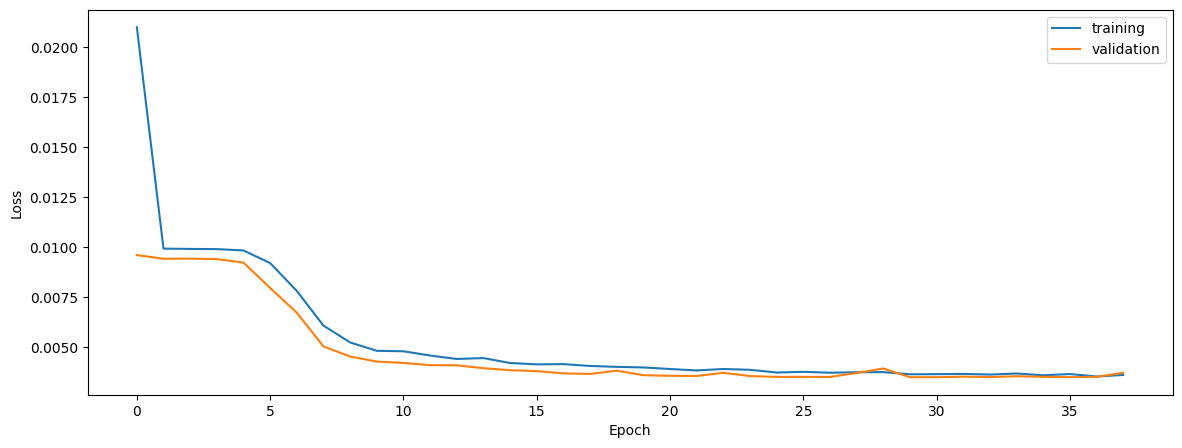

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


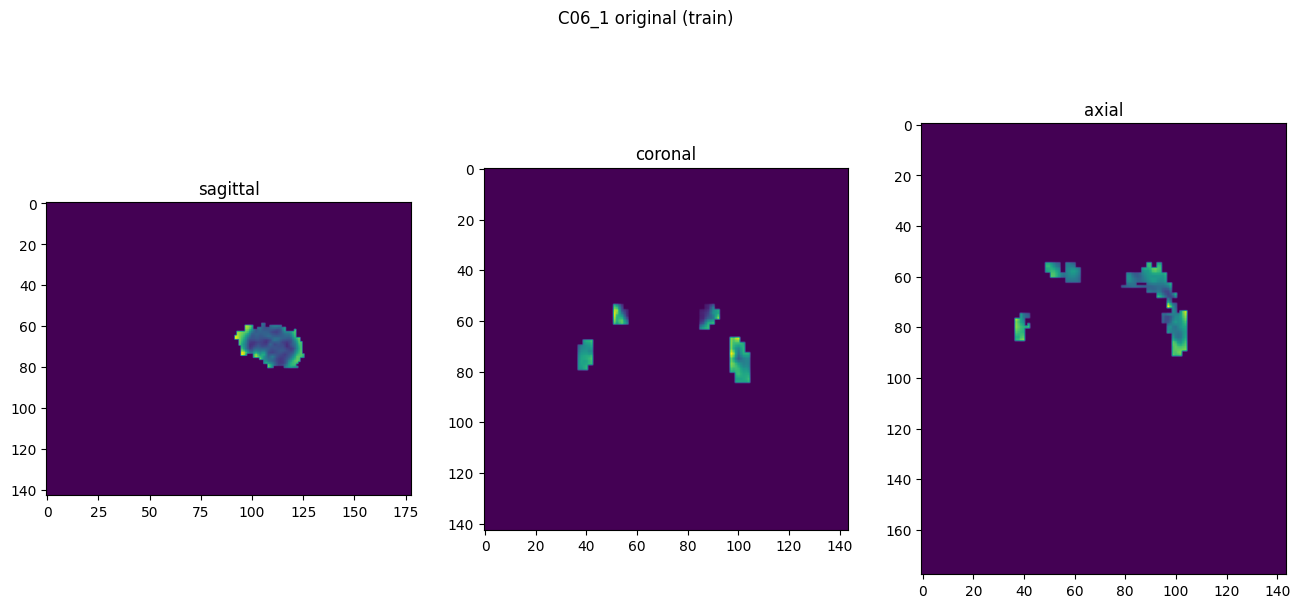

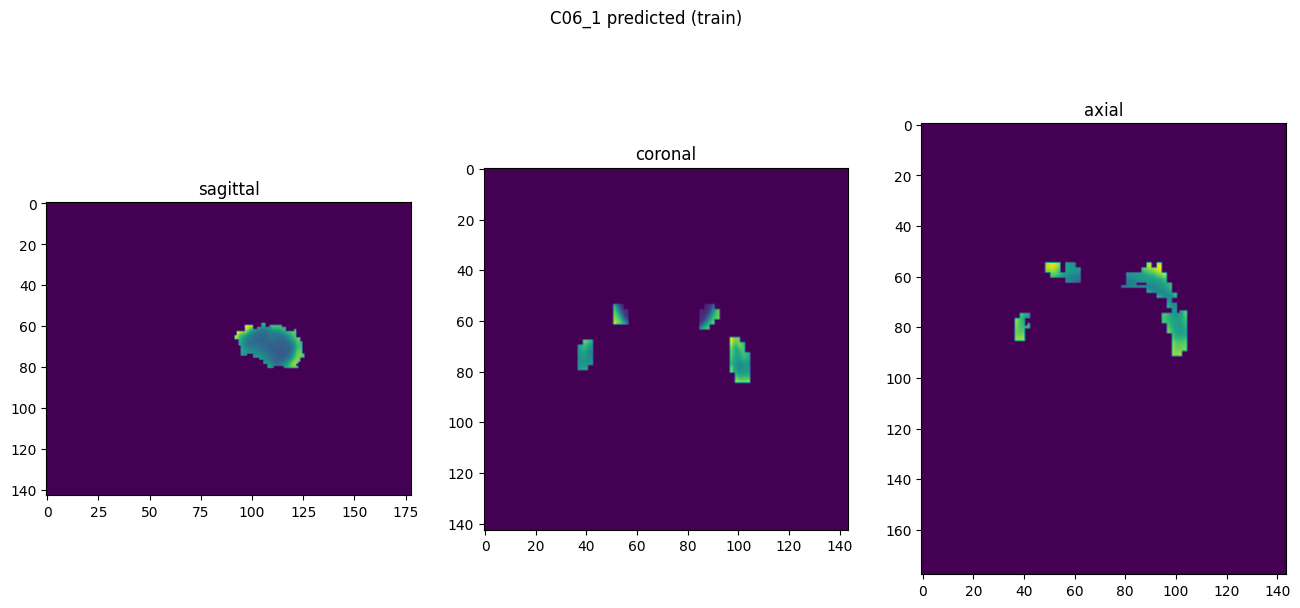

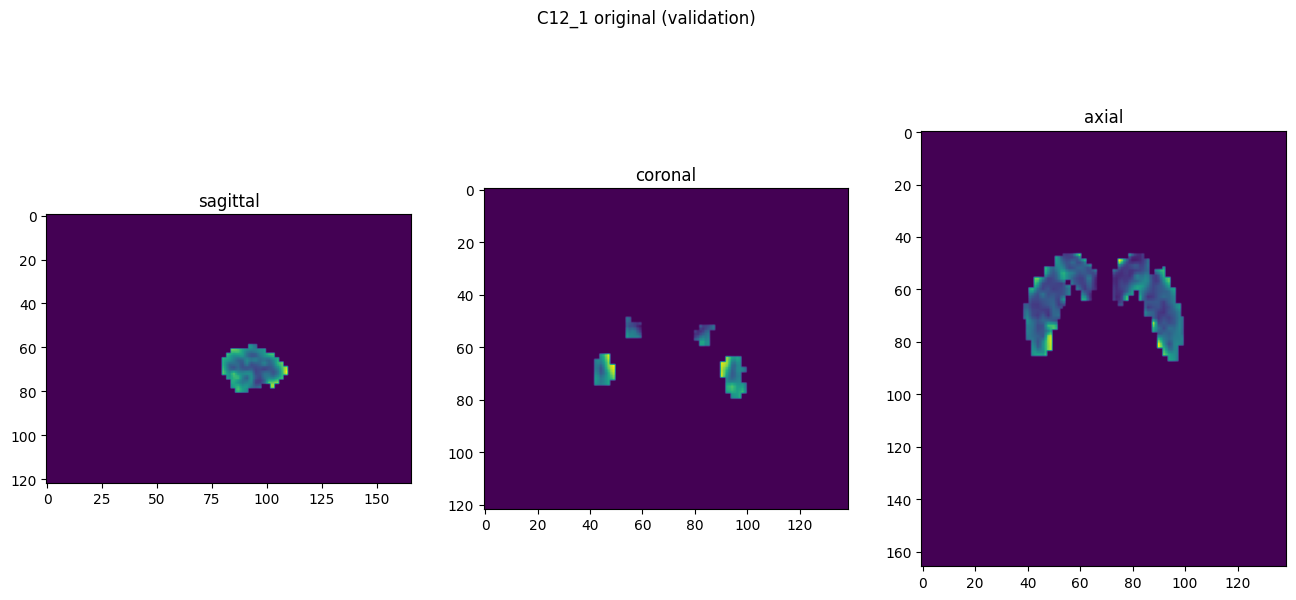

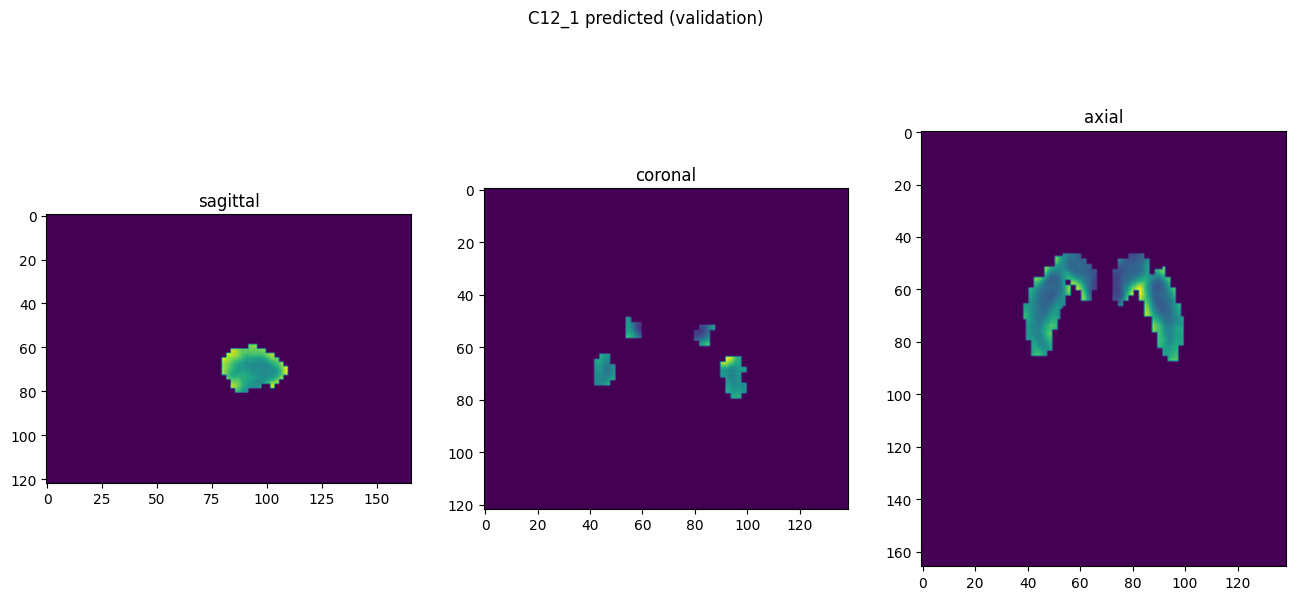

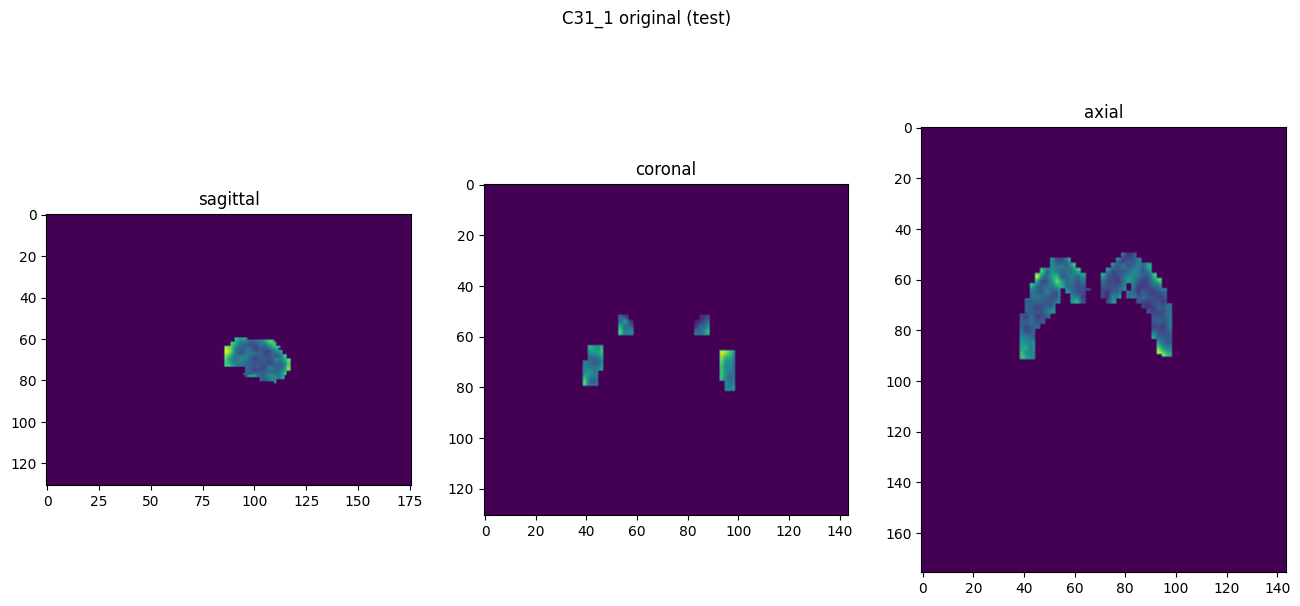

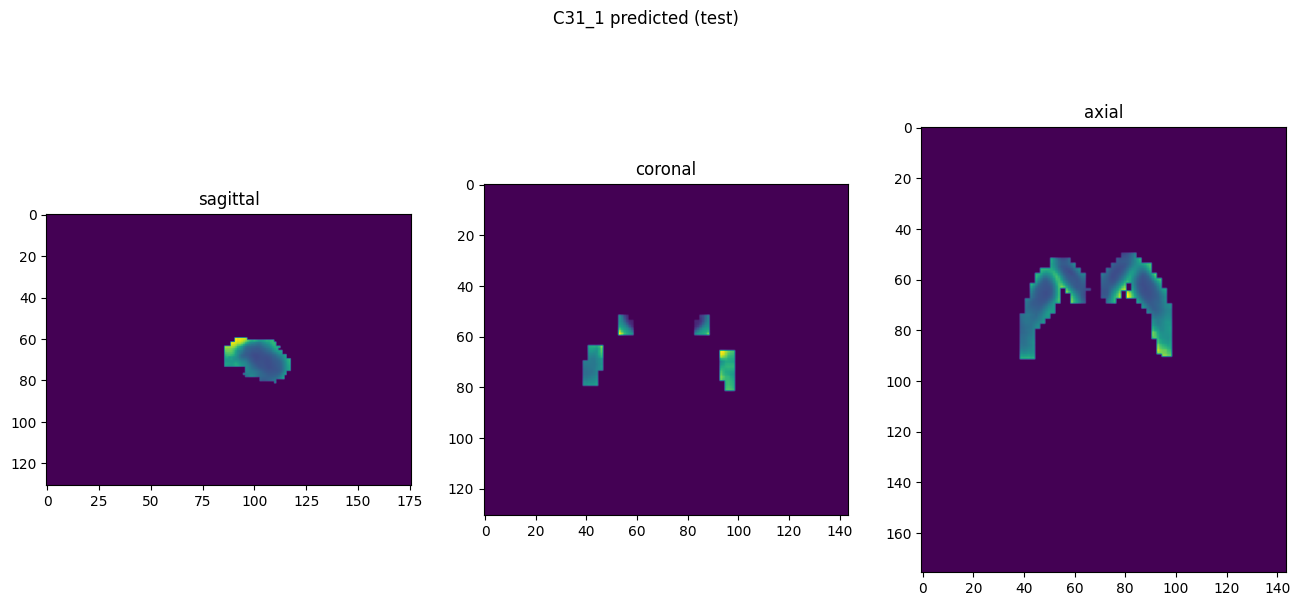

In [10]:
showResults(model, gen, threshold=None, background=False)